# Reinforcement Learning Offline

In [45]:
# import libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import auxiliar_functions as af
import d3rlpy
# You can split dataset into a training dataset and a test dataset just like supervised learning as follows.
from sklearn.model_selection import train_test_split
# Collecting evaluation metrics is important to train algorithms properly. In d3rlpy, the metrics is computed through scikit-learn style scorer functions.
from d3rlpy.metrics.scorer import td_error_scorer
from d3rlpy.metrics.scorer import average_value_estimation_scorer
# the algorithm can be directly evaluated with evaluate_on_environment function if the environment is available to interactF
from d3rlpy.metrics.scorer import evaluate_on_environment
from d3rlpy.datasets import get_cartpole # CartPole-v0 dataset
from d3rlpy.datasets import get_pendulum # Pendulum-v0 dataset
from d3rlpy.datasets import get_pybullet # PyBullet task datasets
from d3rlpy.datasets import get_atari    # Atari 2600 task datasets
from d3rlpy.datasets import get_d4rl     # D4RL datasets
from sklearn.preprocessing import MinMaxScaler

In [46]:
variables_interes=['pyrite law', 'chalcopyrite law',
       'chalcocite law', 'covelin law', 'crusher index', 'sag power index',
       'ball work index', 'bornite law','charge cell', 'TPH','water', 'speed','HH TPH', 'granulometry', 'Edad','loss of TPH',
       "power","solid percentage","HH charge cell","LL charge cell","delta HH TPH","delta HH charge cell","delta LL charge cell"]

In [47]:
# read dictionary
tags=pd.read_excel("..\\data\\tags relevantes.xlsx")
tags_cc=tags.tag.to_list()
dic={}
for i,j in zip(tags.tag,tags.description):
    dic[i]=j

In [48]:
# read data
liners_age=pd.read_csv('../data/liners_age_17December2022.csv', parse_dates=['Timestamp'], index_col='Timestamp')
df=pd.read_csv("..\data\cleaned_15December2022.csv", parse_dates=['Timestamp'], index_col='Timestamp')
df.rename(columns=dic,inplace=True)
df=df.join(liners_age).dropna()
df["delta HH TPH"]=df["HH TPH"]-df["TPH"]
df["delta HH charge cell"]=df["HH charge cell"]-df["charge cell"]
df["delta LL charge cell"]=df["charge cell"]-df["LL charge cell"]
df["loss of TPH"]=df["delta HH TPH"].apply(lambda x: -1 if x>100 else 1)
df=df[variables_interes]
# Done MDP: se considera como tarea finalizada cuando el turno termina a las 12:00

scaler = MinMaxScaler()
#df['HH charge cell']=scaler.fit_transform(df['HH charge cell'].values.reshape(-1,1)).squeeze()
df["terminals"]=df.reset_index().apply(lambda x: 1 if x["Timestamp"].strftime("%H:%M")=="12:00" else 0,axis=1).values
df1=pd.DataFrame(scaler.fit_transform(df),columns=df.columns,index=df.index)
df1=df1["2020-01":"2020-02"]

In [16]:
#df1[(df1.reset_index().apply(lambda x: x["Timestamp"].strftime("%H:%M"),axis=1)=="11:00").values]

In [49]:
states=[
 'charge cell',
 'water',
 'speed',
 'HH TPH',
 'granulometry',
 'solid percentage',
 'HH charge cell',
 ]

actions=[
    'HH charge cell'
    ]

reward=[
    "loss of TPH"
    ]

In [50]:
dataset, env = get_pendulum()
episode = dataset.episodes[0]

# access to episode data
print(episode.observations.shape)
print(episode.actions.shape)
print(episode.rewards.shape)


(201, 3)
(201, 1)
(201,)


In [51]:
observations=df1[states].to_numpy()
actions=df1[actions].to_numpy().reshape(-1,1)
rewards=df1[reward].to_numpy().squeeze()
terminals=df1["terminals"].to_numpy()
dataset = d3rlpy.dataset.MDPDataset(
    observations=observations,
    actions=actions,
    rewards=rewards,
    terminals=terminals,
)
print(observations.shape)
print(actions.shape)
print(rewards.shape)
episode = dataset.episodes[0]

# access to episode data
print(episode.observations.shape)
print(episode.actions.shape)
print(episode.rewards.shape)

(11531, 7)
(11531, 1)
(11531,)
(661, 7)
(661, 1)
(661,)


In [52]:
# first episode
episode = dataset.episodes[0]

# access to episode data
episode.observations
episode.actions
episode.rewards

# first transition
transition = episode.transitions[0]

# access to tuple
transition.observation
transition.action
transition.reward
transition.next_observation

# linked list structure
next_transition = transition.next_transition
assert transition is next_transition.prev_transition

In [53]:
# episode-wise split
train_episodes, test_episodes = train_test_split(dataset.episodes)

# setup metrics
metrics = {
  "soft_opc": d3rlpy.metrics.scorer.soft_opc_scorer(return_threshold=180),
  "initial_value": d3rlpy.metrics.scorer.initial_state_value_estimation_scorer,
}

dqn = d3rlpy.algos.AWAC()

# start training with episode-wise splits
data_train=dqn.fit(
    train_episodes,
    n_epochs=10,
    scorers=metrics,
    eval_episodes=test_episodes,
)

2023-07-21 20:10.46 [debug    ] RoundIterator is selected.
2023-07-21 20:10.46 [info     ] Directory is created at d3rlpy_logs\AWAC_20230721201046
2023-07-21 20:10.46 [debug    ] Building models...
2023-07-21 20:10.46 [debug    ] Models have been built.
2023-07-21 20:10.46 [info     ] Parameters are saved to d3rlpy_logs\AWAC_20230721201046\params.json params={'action_scaler': None, 'actor_encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0001, 'amsgrad': False}, 'batch_size': 1024, 'critic_encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'critic_learning_rate': 0.0003, 'critic_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'gamma': 0.99, 'generated_maxle

Epoch 1/10: 100%|██████████| 6/6 [00:00<00:00, 15.98it/s, critic_loss=1.68, actor_loss=40.1, mean_std=0.0498]

2023-07-21 20:10.47 [info     ] AWAC_20230721201046: epoch=1 step=6 epoch=1 metrics={'time_sample_batch': 0.0020519097646077475, 'time_algorithm_update': 0.059498985608418785, 'critic_loss': 1.271182229121526, 'actor_loss': 20.280847708384197, 'mean_std': 0.04986181731025378, 'time_step': 0.06205566724141439, 'soft_opc': 0.0, 'initial_value': 0.35657212138175964} step=6


2023-07-21 20:10.47 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230721201046\model_6.pt


Epoch 2/10: 100%|██████████| 6/6 [00:00<00:00, 19.33it/s, critic_loss=0.801, actor_loss=2.08, mean_std=0.0499]

2023-07-21 20:10.47 [info     ] AWAC_20230721201046: epoch=2 step=12 epoch=2 metrics={'time_sample_batch': 0.001964092254638672, 'time_algorithm_update': 0.04906360308329264, 'critic_loss': 0.5849939286708832, 'actor_loss': -0.7060955489675204, 'mean_std': 0.049958997716506325, 'time_step': 0.05102769533793131, 'soft_opc': 0.0, 'initial_value': 0.6562069058418274} step=12
2023-07-21 20:10.47 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230721201046\model_12.pt



Epoch 3/10: 100%|██████████| 6/6 [00:00<00:00, 11.53it/s, critic_loss=0.348, actor_loss=-.435, mean_std=0.05]

2023-07-21 20:10.48 [info     ] AWAC_20230721201046: epoch=3 step=18 epoch=3 metrics={'time_sample_batch': 0.0022630691528320312, 'time_algorithm_update': 0.08379395802815755, 'critic_loss': 0.27367162704467773, 'actor_loss': 0.6993943825364113, 'mean_std': 0.050015329072872795, 'time_step': 0.08622225125630696, 'soft_opc': 0.0, 'initial_value': 0.9054951667785645} step=18
2023-07-21 20:10.48 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230721201046\model_18.pt



Epoch 4/10: 100%|██████████| 6/6 [00:00<00:00, 14.79it/s, critic_loss=0.202, actor_loss=1.07, mean_std=0.05]

2023-07-21 20:10.48 [info     ] AWAC_20230721201046: epoch=4 step=24 epoch=4 metrics={'time_sample_batch': 0.0023751656214396157, 'time_algorithm_update': 0.06443925698598225, 'critic_loss': 0.19543154537677765, 'actor_loss': -0.05276468644539515, 'mean_std': 0.05005826676885287, 'time_step': 0.06706400712331136, 'soft_opc': 0.0, 'initial_value': 1.0556632280349731} step=24


2023-07-21 20:10.49 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230721201046\model_24.pt


Epoch 5/10: 100%|██████████| 6/6 [00:00<00:00, 20.15it/s, critic_loss=0.191, actor_loss=-1.42, mean_std=0.0501]

2023-07-21 20:10.49 [info     ] AWAC_20230721201046: epoch=5 step=30 epoch=5 metrics={'time_sample_batch': 0.0019063552220662434, 'time_algorithm_update': 0.04690062999725342, 'critic_loss': 0.18879720320304236, 'actor_loss': -1.7123681704203289, 'mean_std': 0.05008943441013495, 'time_step': 0.0491405725479126, 'soft_opc': 0.0, 'initial_value': 1.0952612161636353} step=30


2023-07-21 20:10.49 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230721201046\model_30.pt


Epoch 6/10: 100%|██████████| 6/6 [00:00<00:00, 23.55it/s, critic_loss=0.172, actor_loss=-1.74, mean_std=0.0501]

2023-07-21 20:10.49 [info     ] AWAC_20230721201046: epoch=6 step=36 epoch=6 metrics={'time_sample_batch': 0.0016039212544759114, 'time_algorithm_update': 0.04053135712941488, 'critic_loss': 0.1831966688235601, 'actor_loss': -1.5506003896395366, 'mean_std': 0.0501079335808754, 'time_step': 0.04230193297068278, 'soft_opc': 0.0, 'initial_value': 1.0710265636444092} step=36
2023-07-21 20:10.49 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230721201046\model_36.pt



Epoch 7/10: 100%|██████████| 6/6 [00:00<00:00, 21.87it/s, critic_loss=0.164, actor_loss=-1.44, mean_std=0.0501]

2023-07-21 20:10.50 [info     ] AWAC_20230721201046: epoch=7 step=42 epoch=7 metrics={'time_sample_batch': 0.0016200939814249675, 'time_algorithm_update': 0.043379743893941246, 'critic_loss': 0.16768566767374674, 'actor_loss': -1.58057697614034, 'mean_std': 0.05011987127363682, 'time_step': 0.04516669114430746, 'soft_opc': 0.0, 'initial_value': 1.0476393699645996} step=42


2023-07-21 20:10.50 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230721201046\model_42.pt


Epoch 8/10: 100%|██████████| 6/6 [00:00<00:00, 22.78it/s, critic_loss=0.157, actor_loss=-1.76, mean_std=0.0501]

2023-07-21 20:10.50 [info     ] AWAC_20230721201046: epoch=8 step=48 epoch=8 metrics={'time_sample_batch': 0.0014218886693318684, 'time_algorithm_update': 0.04181822141011556, 'critic_loss': 0.1665201261639595, 'actor_loss': -1.8301455179850261, 'mean_std': 0.05012744665145874, 'time_step': 0.04340656598409017, 'soft_opc': 0.0, 'initial_value': 1.057729721069336} step=48


2023-07-21 20:10.50 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230721201046\model_48.pt


Epoch 9/10: 100%|██████████| 6/6 [00:00<00:00, 22.51it/s, critic_loss=0.161, actor_loss=-1.86, mean_std=0.0501]

2023-07-21 20:10.50 [info     ] AWAC_20230721201046: epoch=9 step=54 epoch=9 metrics={'time_sample_batch': 0.0019248723983764648, 'time_algorithm_update': 0.04199596246083578, 'critic_loss': 0.16181162496407828, 'actor_loss': -1.8319851954778035, 'mean_std': 0.05013123030463854, 'time_step': 0.0440895160039266, 'soft_opc': 0.0, 'initial_value': 1.097392201423645} step=54
2023-07-21 20:10.50 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230721201046\model_54.pt



Epoch 10/10: 100%|██████████| 6/6 [00:00<00:00, 20.44it/s, critic_loss=0.141, actor_loss=-1.84, mean_std=0.0501]

2023-07-21 20:10.51 [info     ] AWAC_20230721201046: epoch=10 step=60 epoch=10 metrics={'time_sample_batch': 0.0015150705973307292, 'time_algorithm_update': 0.046840389569600425, 'critic_loss': 0.15909142543872198, 'actor_loss': -1.8575377662976582, 'mean_std': 0.050132766366004944, 'time_step': 0.04858362674713135, 'soft_opc': 0.0, 'initial_value': 1.1394283771514893} step=60
2023-07-21 20:10.51 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230721201046\model_60.pt


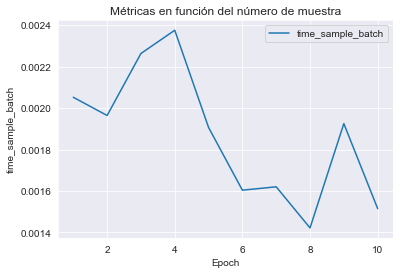

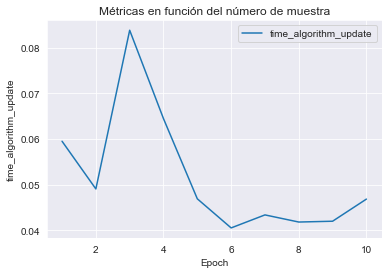

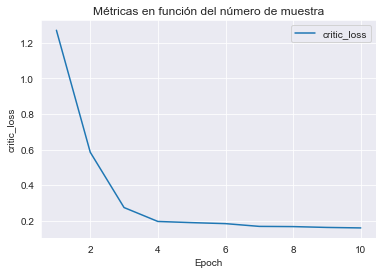

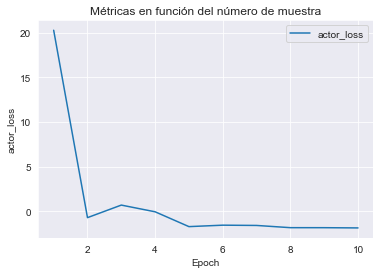

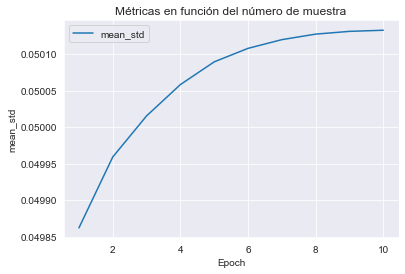

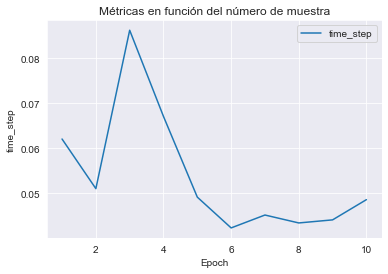

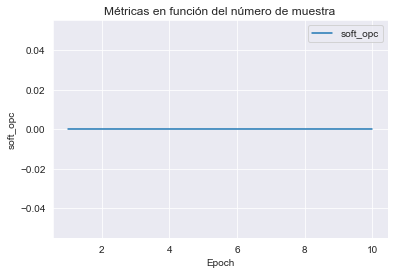

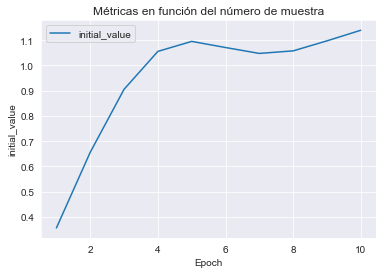

In [54]:
# Métricas que queremos graficar
metrics_to_plot = list(data_train[0][1].keys())

# Crear un gráfico de líneas para cada métrica
for metric in metrics_to_plot:
    x = [entry[0] for entry in data_train]
    y = [entry[1][metric] for entry in data_train]
    plt.plot(x, y, label=metric)

    # Etiquetas y título del gráfico
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.title('Métricas en función del número de muestra')
    plt.legend()

    # Mostrar el gráfico
    plt.show()

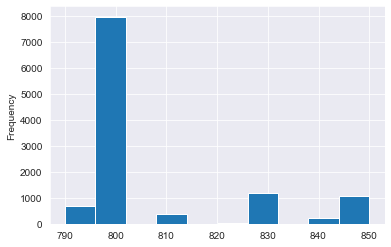

In [55]:
df_fin=pd.DataFrame()
df_fin["HH charge cell"]=dqn.predict([observations]).squeeze()
df_fin=pd.DataFrame(scaler.inverse_transform(df1),columns=df1.columns)
df_fin["HH charge cell"].plot(kind="hist")
plt.show()

In [56]:
df_fin["HH charge cell"].describe()

count    11531.000000
mean       808.261426
std         17.209193
min        790.000000
25%        800.000000
50%        800.000000
75%        805.000003
max        850.000000
Name: HH charge cell, dtype: float64

In [29]:
# return actions based on the greedy-policy
action = dqn.predict([observations[100]])[0]
action

array([0.4706816], dtype=float32)

In [30]:
# estimate action-values
value = dqn.predict_value([observations[0]], [action])[0]
value

1.4062424

# Create Your Dataset

**The data collection API is introduced in Data Collection. In this tutorial, you can learn how to build your dataset from logged data such as the user data collected in your web service.**

### Prepare Logged Data

**First of all, you need to prepare your logged data. In this tutorial, let’s use randomly generated data. terminals represents the last step of episodes. If terminals[i] == 1.0, i-th step is the terminal state. Otherwise you need to set zeros for non-terminal states.**

In [3]:
# vector observation
# 1000 steps of observations with shape of (100,)
observations = np.random.random((1000, 100))

# 1000 steps of actions with shape of (4,)
actions = np.random.random((1000, 4))
actions=np.random.randint(2, size=1000)
# 1000 steps of rewards
rewards = np.random.random(1000)

# 1000 steps of terminal flags
terminals = np.random.randint(2, size=1000)

In [4]:
dataset = d3rlpy.dataset.MDPDataset(
    observations=observations,
    actions=actions,
    rewards=rewards,
    terminals=terminals,
)

In [33]:
# You can make your own dataset without any efforts. In this tutorial, let’s use integrated datasets to start. If you want to make a new dataset, see MDPDataset.
#ataset, env = get_cartpole()
dataset, env = get_pendulum()

In [34]:
# first episode
episode = dataset.episodes[0]

# access to episode data
episode.observations
episode.actions
episode.rewards

# first transition
transition = episode.transitions[0]

# access to tuple
transition.observation
transition.action
transition.reward
transition.next_observation

# linked list structure
next_transition = transition.next_transition
assert transition is next_transition.prev_transition

In [35]:
dqn = d3rlpy.algos.AWAC(use_gpu=False)

In [36]:
# initialize neural networks with the given observation shape and action size.
# this is not necessary when you directly call fit or fit_online method.
dqn.build_with_dataset(dataset)

In [37]:
# episode-wise split
train_episodes, test_episodes = train_test_split(dataset.episodes)

In [38]:
# calculate metrics with test dataset
td_error = td_error_scorer(dqn, test_episodes)
td_error

6.598667144787332

In [39]:
# set environment in scorer function
evaluate_scorer = evaluate_on_environment(env)

In [40]:
# episode-wise split
#train_episodes, test_episodes = train_test_split(dataset.episodes)

# setup metrics
metrics = {
  "soft_opc": d3rlpy.metrics.scorer.soft_opc_scorer(return_threshold=180),
  "initial_value": d3rlpy.metrics.scorer.initial_state_value_estimation_scorer,
  'environment': evaluate_scorer
}

# start training with episode-wise splits
data_train=dqn.fit(
    train_episodes,
    #n_steps=10000,
    scorers=metrics,
    n_epochs=10,
    eval_episodes=test_episodes,
)

2023-07-21 20:06.26 [debug    ] RoundIterator is selected.
2023-07-21 20:06.26 [info     ] Directory is created at d3rlpy_logs\AWAC_20230721200626
2023-07-21 20:06.26 [warning  ] Skip building models since they're already built.
2023-07-21 20:06.26 [info     ] Parameters are saved to d3rlpy_logs\AWAC_20230721200626\params.json params={'action_scaler': None, 'actor_encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0001, 'amsgrad': False}, 'batch_size': 1024, 'critic_encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'critic_learning_rate': 0.0003, 'critic_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'gamma': 0.99, 'generated_maxlen': 100000, 'lam': 1.0, '

Epoch 1/10: 100%|██████████| 72/72 [00:04<00:00, 17.70it/s, critic_loss=5.05, actor_loss=2.71e+3, mean_std=0.0506]


2023-07-21 20:06.32 [info     ] AWAC_20230721200626: epoch=1 step=72 epoch=1 metrics={'time_sample_batch': 0.002107166581683689, 'time_algorithm_update': 0.05377635359764099, 'critic_loss': 5.0078240599897175, 'actor_loss': 2707.859134250217, 'mean_std': 0.050574364295850195, 'time_step': 0.056047293874952525, 'soft_opc': nan, 'initial_value': -1.9744960069656372, 'environment': -1212.8160306456439} step=72
2023-07-21 20:06.32 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230721200626\model_72.pt


Epoch 2/10: 100%|██████████| 72/72 [00:04<00:00, 17.33it/s, critic_loss=0.88, actor_loss=2.26e+3, mean_std=0.0521]


2023-07-21 20:06.38 [info     ] AWAC_20230721200626: epoch=2 step=144 epoch=2 metrics={'time_sample_batch': 0.0022320515579647487, 'time_algorithm_update': 0.05498972866270277, 'critic_loss': 0.876454070624378, 'actor_loss': 2261.1187269422744, 'mean_std': 0.052066375553194016, 'time_step': 0.057354132334391274, 'soft_opc': nan, 'initial_value': -3.2409963607788086, 'environment': -659.6239336232214} step=144
2023-07-21 20:06.38 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230721200626\model_144.pt


Epoch 3/10: 100%|██████████| 72/72 [00:05<00:00, 13.35it/s, critic_loss=0.339, actor_loss=2e+3, mean_std=0.0535]   


2023-07-21 20:06.45 [info     ] AWAC_20230721200626: epoch=3 step=216 epoch=3 metrics={'time_sample_batch': 0.0027799738778008353, 'time_algorithm_update': 0.07137992646959093, 'critic_loss': 0.33833449126945603, 'actor_loss': 1990.119613647461, 'mean_std': 0.05354897983165251, 'time_step': 0.07431629631254408, 'soft_opc': nan, 'initial_value': -4.124007701873779, 'environment': -695.6500670961514} step=216
2023-07-21 20:06.45 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230721200626\model_216.pt


Epoch 4/10: 100%|██████████| 72/72 [00:04<00:00, 14.84it/s, critic_loss=0.206, actor_loss=1.75e+3, mean_std=0.055] 


2023-07-21 20:06.52 [info     ] AWAC_20230721200626: epoch=4 step=288 epoch=4 metrics={'time_sample_batch': 0.002664433585272895, 'time_algorithm_update': 0.06394666102197435, 'critic_loss': 0.20498876832425594, 'actor_loss': 1744.58031378852, 'mean_std': 0.054971458649055824, 'time_step': 0.0667676826318105, 'soft_opc': nan, 'initial_value': -4.944882392883301, 'environment': -641.411653583339} step=288
2023-07-21 20:06.52 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230721200626\model_288.pt


Epoch 5/10: 100%|██████████| 72/72 [00:05<00:00, 12.61it/s, critic_loss=0.149, actor_loss=1.63e+3, mean_std=0.0564]


2023-07-21 20:06.59 [info     ] AWAC_20230721200626: epoch=5 step=360 epoch=5 metrics={'time_sample_batch': 0.0026621222496032715, 'time_algorithm_update': 0.07583190666304694, 'critic_loss': 0.1484600060308973, 'actor_loss': 1630.3587544759114, 'mean_std': 0.05636723054986861, 'time_step': 0.07870780097113715, 'soft_opc': nan, 'initial_value': -5.805241107940674, 'environment': -488.2869813248487} step=360
2023-07-21 20:06.59 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230721200626\model_360.pt


Epoch 6/10: 100%|██████████| 72/72 [00:05<00:00, 12.33it/s, critic_loss=0.12, actor_loss=1.56e+3, mean_std=0.0578] 


2023-07-21 20:07.07 [info     ] AWAC_20230721200626: epoch=6 step=432 epoch=6 metrics={'time_sample_batch': 0.0027048521571689183, 'time_algorithm_update': 0.07766156395276387, 'critic_loss': 0.11992197980483373, 'actor_loss': 1558.4801381429036, 'mean_std': 0.05779680790793565, 'time_step': 0.0805427696969774, 'soft_opc': nan, 'initial_value': -6.769272804260254, 'environment': -756.8678400149041} step=432
2023-07-21 20:07.07 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230721200626\model_432.pt


Epoch 7/10: 100%|██████████| 72/72 [00:05<00:00, 14.34it/s, critic_loss=0.102, actor_loss=1.49e+3, mean_std=0.0592] 


2023-07-21 20:07.14 [info     ] AWAC_20230721200626: epoch=7 step=504 epoch=7 metrics={'time_sample_batch': 0.0026577942901187474, 'time_algorithm_update': 0.06632116105821398, 'critic_loss': 0.10212490614503622, 'actor_loss': 1491.2406497531467, 'mean_std': 0.05925710287152065, 'time_step': 0.06916899813546075, 'soft_opc': nan, 'initial_value': -7.763460159301758, 'environment': -390.553987395272} step=504
2023-07-21 20:07.14 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230721200626\model_504.pt


Epoch 8/10: 100%|██████████| 72/72 [00:04<00:00, 14.45it/s, critic_loss=0.0922, actor_loss=1420.86, mean_std=0.0607]


2023-07-21 20:07.20 [info     ] AWAC_20230721200626: epoch=8 step=576 epoch=8 metrics={'time_sample_batch': 0.002499259180492825, 'time_algorithm_update': 0.06598211990462409, 'critic_loss': 0.0920658643460936, 'actor_loss': 1421.4460228814019, 'mean_std': 0.06074898265716103, 'time_step': 0.06863530808024937, 'soft_opc': nan, 'initial_value': -8.800910949707031, 'environment': -505.20084402358816} step=576
2023-07-21 20:07.20 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230721200626\model_576.pt


Epoch 9/10: 100%|██████████| 72/72 [00:05<00:00, 13.42it/s, critic_loss=0.084, actor_loss=1.35e+3, mean_std=0.0622] 


2023-07-21 20:07.27 [info     ] AWAC_20230721200626: epoch=9 step=648 epoch=9 metrics={'time_sample_batch': 0.0026607579655117458, 'time_algorithm_update': 0.0711123678419325, 'critic_loss': 0.08405422693532374, 'actor_loss': 1354.0418853759766, 'mean_std': 0.062251048576500684, 'time_step': 0.07396954629156324, 'soft_opc': nan, 'initial_value': -9.880091667175293, 'environment': -397.7783077596051} step=648
2023-07-21 20:07.27 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230721200626\model_648.pt


Epoch 10/10: 100%|██████████| 72/72 [00:05<00:00, 13.75it/s, critic_loss=0.0794, actor_loss=1.29e+3, mean_std=0.0638]


2023-07-21 20:07.34 [info     ] AWAC_20230721200626: epoch=10 step=720 epoch=10 metrics={'time_sample_batch': 0.002705358796649509, 'time_algorithm_update': 0.0693013568719228, 'critic_loss': 0.07928291666838858, 'actor_loss': 1290.429692586263, 'mean_std': 0.06376980690078603, 'time_step': 0.0721600419945187, 'soft_opc': nan, 'initial_value': -11.08092212677002, 'environment': -262.67879468196077} step=720
2023-07-21 20:07.34 [info     ] Model parameters are saved to d3rlpy_logs\AWAC_20230721200626\model_720.pt


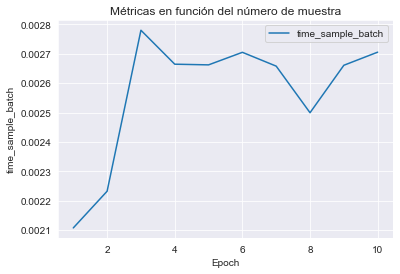

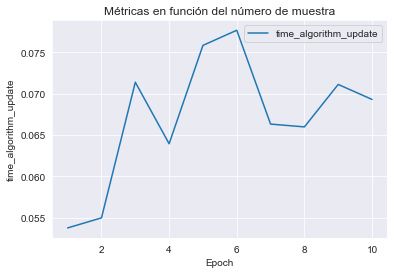

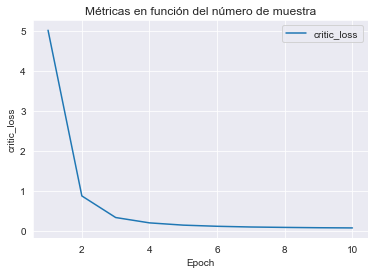

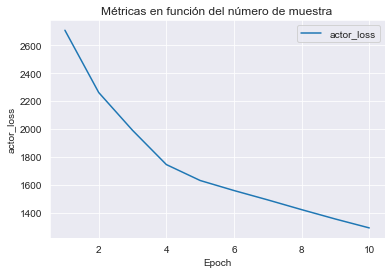

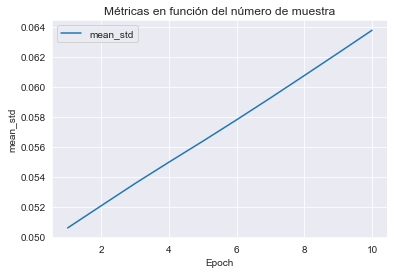

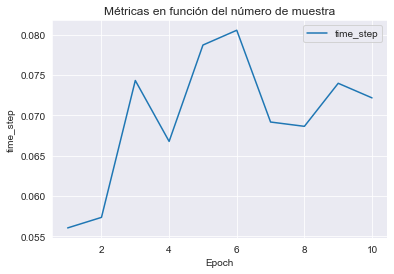

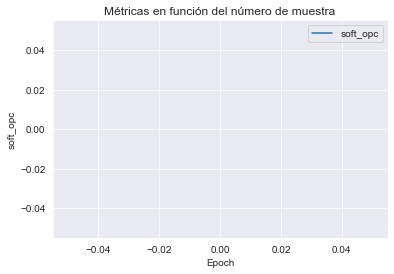

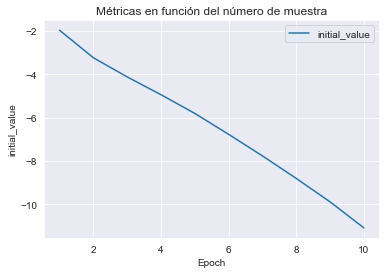

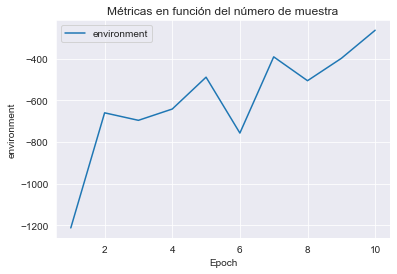

In [41]:
# Métricas que queremos graficar
metrics_to_plot = list(data_train[0][1].keys())

# Crear un gráfico de líneas para cada métrica
for metric in metrics_to_plot:
    x = [entry[0] for entry in data_train]
    y = [entry[1][metric] for entry in data_train]
    plt.plot(x, y, label=metric)

    # Etiquetas y título del gráfico
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.title('Métricas en función del número de muestra')
    plt.legend()

    # Mostrar el gráfico
    plt.show()

In [42]:
# calculate metrics with test dataset
td_error = td_error_scorer(dqn, test_episodes)
td_error

5.62119210275548

In [43]:
# Once the training is done, your algorithm is ready to make decisions.
observation = env.reset()

# return actions based on the greedy-policy
action = dqn.predict([observation])[0]

# estimate action-values
value = dqn.predict_value([observation], [action])[0]

In [74]:
# save full parameters only
dqn.save_model('dqn.pt')
# load full parameters with manual setup
dqn3 =d3rlpy.algos.DQN()
dqn3.build_with_dataset(dataset)
dqn3.load_model('dqn.pt')